<a href="https://colab.research.google.com/github/asrenninger/urbansim/blob/main/automl/automl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mljar-supervised

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/126.8 kB ? eta -:--:--
     ------------------------- ------------- 81.9/126.8 kB 2.2 MB/s eta 0:00:01
     -------------------------------------- 126.8/126.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for lightgbm>=3.0.0 from https://files.pythonhosted.org/packages/e1/4c/4685ccfae9806f561de716e32549190c1f533dde5bcadaf83bdf23972cf0/lightgbm-4.3.0-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for dtreeviz>=2.2.2 from https://files.pythonhosted.org/packages/b3/e8/44eb59345d8ba9d2f6610df6441d63082f46021c1685de24716c22f55383/dtreeviz-2.2.2-py3-none-any.whl.metadata
  Obtaining dependency information for shap>=0.42.1 from https://files.pythonhosted.org/packages/39/6c/4ab39615fc3ffe40faaa62fc2feb43868b8ce946c671e84bf476c1e06116/s

This workflow is really simple..

In [2]:
# import libraries
import pandas as pd
import numpy as np

from supervised.automl import AutoML

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# make sure we can see the plots
%matplotlib inline

In [4]:
# mount to Google Drive so we can import the data
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# read in the data wherever you stored it
df = pd.read_csv("drive/MyDrive/urbansim/migration.csv")

In [5]:
df = pd.read_csv("https://github.com/asrenninger/urbansim/raw/main/automl/migration.csv.gz")

In [ ]:
# or you can read it in from github
# df = pd.read_csv("https://github.com/asrenninger/urbansim/raw/main/automl/migration.csv.gz")

In [6]:
# I'm listing the columns so below I can see what I want to keep
df.columns

Index(['code_i', 'code_j', 'F_ij', 'distance', 'name_i', 'name_j', 'density_i',
       'married_i', 'households_i', 'population_i', 'nonwhite_i',
       'unhealthy_i', 'employed_i', 'university_i', 'density_j', 'married_j',
       'households_j', 'population_j', 'nonwhite_j', 'unhealthy_j',
       'employed_j', 'university_j'],
      dtype='object')

AutoML has several modes—Explain, Perform, Compete. They all use different combinations of models to create the best prediction. The lightest, fastest possible collection of models is Explain, so we will stick with that to make it run faster.

In [8]:
# create training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    # we are going to throw out the first 2 columns
    df[df.columns[3:]], df["F_ij"], test_size=0.25
)

# the results_path should point to a folder that you have already created to store the model results
automl = AutoML(results_path="automl", mode='Explain')
# fit the model
automl.fit(X_train, y_train)

Linear algorithm was disabled.
AutoML directory: automl
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 135.245587 trained in 0.29 seconds


C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\supervised\utils\shap.py:116: UserWarning: The figure layout has changed to tight


2_DecisionTree rmse 98.320859 trained in 14.69 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 77.450562 trained in 13.21 seconds
4_Default_NeuralNetwork rmse 89.938596 trained in 3.86 seconds


C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\shap\plots\_beeswarm.py:962: UserWarning: The figure layout has changed to tight
C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\supervised\utils\shap.py:116: UserWarning: The figure layout has changed to tight


5_Default_RandomForest rmse 84.149797 trained in 8.25 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 73.377685 trained in 0.17 seconds
AutoML fit time: 46.1 seconds
AutoML best model: Ensemble


AutoML(results_path='automl')

See that AutoML saves the model as to your folder. Go to the directory and check out the model. There should be Feature Importance images in each model folder. These compute the "importance" of each variable by shuffling them one-by-one and seeing how much a completely random version hurts model performance. What are some important features?

In [9]:
# let's store predictions
y_pred = automl.predict(X_test)

There are lot of model evaluation metrics in [sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [10]:
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, r2_score
# percent error
print(mean_absolute_percentage_error(y_test, y_pred))
# absolute error
print(median_absolute_error(y_test, y_pred))
# r-squared
print(r2_score(y_test, y_pred))

1.1194851189946242
3.6737206047165185
0.6974873746244676


Why do you think these are useful metrics, compared to something like RMSE?

In [11]:
# bin the predictions so we can see which parts of the distribution we are predicting best with
y_eval = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
y_eval['quantile'] = pd.qcut(y_eval['y_test'], 10, duplicates='drop')
y_eval['quantile'] = y_eval['quantile'].apply(lambda x: x.mid)

C:\Users\dune\AppData\Local\Temp\ipykernel_33656\1186874090.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


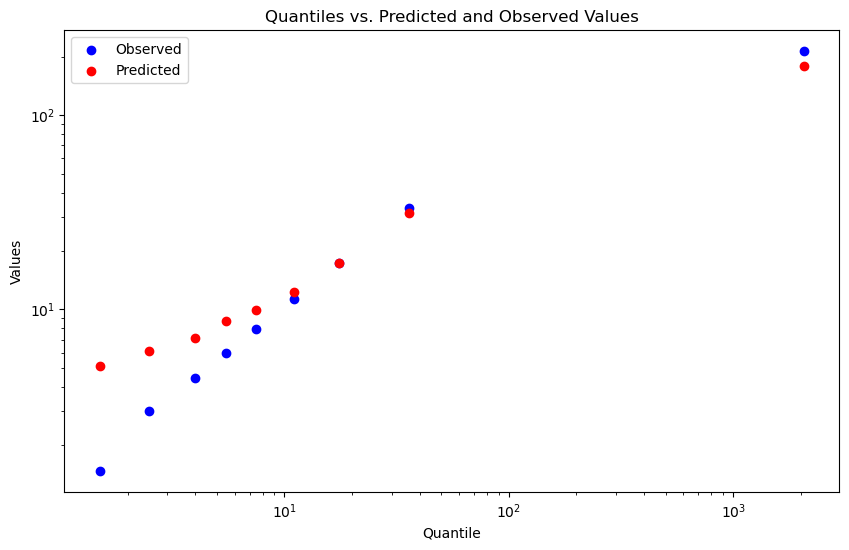

In [12]:
# average error per quantile
y_tile = y_eval.groupby('quantile', as_index=False).agg({'y_pred': 'mean', 'y_test': 'mean'})

import matplotlib.pyplot as plt
# sort the DataFrame by decile for plotting
y_tile.sort_values('quantile', inplace=True)

# create a figure and an axes instance
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot for observed values on ax
ax.scatter(y_tile['quantile'], y_tile['y_test'], color='blue', label='Observed')

# scatter plot for predicted values on ax
ax.scatter(y_tile['quantile'], y_tile['y_pred'], color='red', label='Predicted')

# adding labels and legend
ax.set_xlabel('Quantile')
ax.set_ylabel('Values')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

# show plot
plt.show()

It seems like we are predicting well everywhere except the low end of the distribution

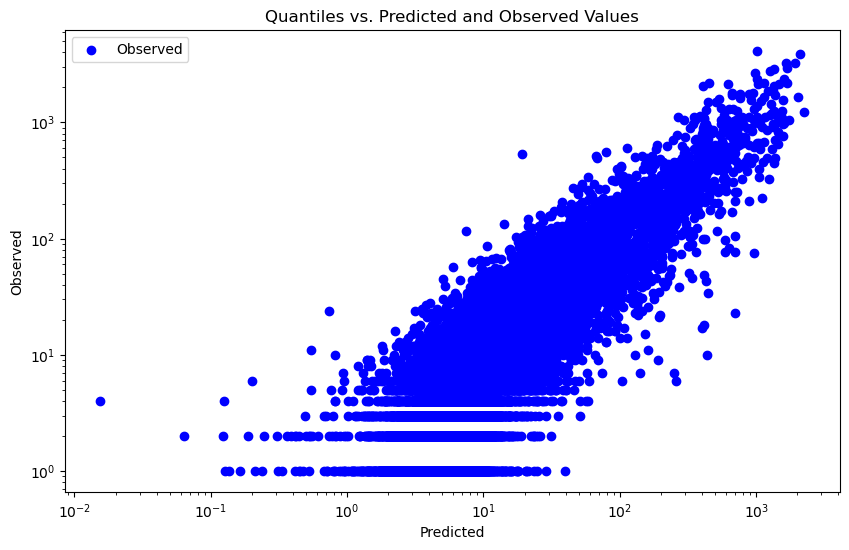

In [13]:
# predictions against observations
y_eval.sort_values('quantile', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_eval['y_pred'], y_eval['y_test'], color='blue', label='Observed')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

plt.show()

# Challenge

Create a new folder called "perform", then run AutoML again with a new results_path but instead of "Explain" use "Perform" as its mode. This will use more models in the stacking and should get better results. Show some metrics from `sklearn`and plot some results; can you show that the new "Perform" model did better or worse?